# Transfer Learning 

Jimmy Gardner 
Metis 21'

In [12]:
import os
from pathlib import Path
import shutil as sh

In [13]:
siberian_stock = '/Users/jamesgardner/Desktop/ConvolutionalNN/Siberian_Binary'
scottish_stock = '/Users/jamesgardner/Desktop/ConvolutionalNN/Scottish_Binary'

In [14]:
base_directory = '/Users/jamesgardner/Desktop/ConvolutionalNN/Splts_new_Binary'
os.mkdir(base_directory)


In [15]:
# train directory
train = os.path.join(base_directory,'train')
os.mkdir(train)

# val directory
val = os.path.join(base_directory,'validation')
os.mkdir(val)

# test directory
test = os.path.join(base_directory,'test')
os.mkdir(test)



In [16]:
# defining function for making train_val_test directories for each class
def make_train_val_test(sub_directories,ttv_directiories,directory_names):
    '''
    
    Output: train, validation , and test directories for each class
    
    sub_directories: list of names for each class
    ttv_directories: train,test,split file paths
    directory_names: name for each class directory splits
    '''
    
    file_names = []
    for i in range(2):
        file_names_class = []
        for j in range(len(ttv_directories)):
            directory_names[i][j] = os.path.join(ttv_directories[j],sub_directories[i])
            os.mkdir(directory_names[i][j])
            file_names_class.append(directory_names[i][j])
        file_names.append(file_names_class)
    
    return file_names

In [17]:
def distribute_images(file_names,bas_dir):
    
    '''
    Distributing images to each train, validation, and test directories for each class
    
    file_names: directories to put images in 
    base_dir: path to directories 
    
    '''
    
    for i in range(len(bas_dir)):
        parent_list = os.listdir(base_dir[i])
        count=0
    
        for child in parent_list:
            if count<1200:
        
            # /Users/jamesgardner/Desktop/ConvolutionalNN/Siberian/siberian0.jpg
                src = os.path.join(base_dir[i], child)
                dst = os.path.join(file_names[i][0], child)
                sh.copyfile(src, dst)
            
            elif count >= 1200 and count <1600:
                src = os.path.join(base_dir[i], child)
                dst = os.path.join(file_names[i][1], child)
                sh.copyfile(src, dst)
            
            elif count >= 1600 and count <2000:
                src = os.path.join(base_dir[i], child)
                dst = os.path.join(file_names[i][2], child)
                sh.copyfile(src, dst)
       
            count += 1 

In [18]:
# defining lists for use in make_train_val_test
# add class name to sub_directories and directory_names if you want to extend to multi-class
sub_directories = ['SF','SB']
ttv_directories = [train,val,test]
directory_names = [['train_scottish','val_scottish','test_scottish'],
                   ['train_siberian','val_siberian','test_siberian']]
base_dir = [scottish_stock,siberian_stock]

file_names = make_train_val_test(sub_directories,ttv_directories,directory_names)
distribute_images(file_names,base_dir)

# Feature Extraction using VGG16

In [19]:
import keras
keras.__version__
from tensorflow.keras.applications import VGG16

# defining convolutional base
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))



In [20]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
# add to shape = (sample_count,however many classes)
# change class_mode to 'catergorical'
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False)
    
    
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    
    
    return features, labels, generator

train_features, train_labels,generator_train = extract_features(train, 2398)
validation_features, validation_labels,generator_val = extract_features(val, 800)
test_features, test_labels,generator_test = extract_features(test, 800)


Found 2398 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


# Reshaping for model use

In [21]:
train_features = np.reshape(train_features, (2398, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (800, 4 * 4 * 512))
test_features = np.reshape(test_features, (800, 4 * 4 * 512))


# Running Model (Transfer Learning)

In [22]:
# activation to softmax
# loss to catergorical cross entropy 
from keras import models
from keras import layers
from keras import optimizers
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten

model_5 = models.Sequential()
#model_5.add(Conv2D(64, kernel_size=3, activation='relu', input_dim=4*4*512))
model_5.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model_5.add(layers.Dropout(0.5))
model_5.add(layers.Dense(1, activation='sigmoid'))
# change units to number of classes 
#model_5.add(Dense(units=3,activation="softmax"))

# for loss use 'catergorical_crossentropy'
model_5.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model_5.fit(train_features, train_labels,
                    epochs=55,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

/Users/jamesgardner/opt/anaconda3/envs/metis/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/55
120/120 [==============================] - 14s 11ms/step - loss: 0.7403 - acc: 0.5511 - val_loss: 0.5364 - val_acc: 0.7300
Epoch 2/55
120/120 [==============================] - 1s 8ms/step - loss: 0.5039 - acc: 0.7622 - val_loss: 0.4535 - val_acc: 0.8075
Epoch 3/55
120/120 [==============================] - 1s 8ms/step - loss: 0.4327 - acc: 0.8099 - val_loss: 0.4348 - val_acc: 0.8037
Epoch 4/55
120/120 [==============================] - 1s 8ms/step - loss: 0.3843 - acc: 0.8342 - val_loss: 0.3814 - val_acc: 0.8338
Epoch 5/55
120/120 [==============================] - 1s 8ms/step - loss: 0.3423 - acc: 0.8623 - val_loss: 0.3620 - val_acc: 0.8487
Epoch 6/55
120/120 [==============================] - 1s 8ms/step - loss: 0.3523 - acc: 0.8519 - val_loss: 0.3529 - val_acc: 0.8525
Epoch 7/55
120/120 [==============================] - 1s 9ms/step - loss: 0.3211 - acc: 0.8643 - val_loss: 0.3390 - val_acc: 0.8575
Epoch 8/55
120/120 [==============================] - 1s 9ms/step - loss: 

In [23]:
accuracy = model_5.evaluate(x=validation_features,y=validation_labels,batch_size=32)
print("Accuracy: ", accuracy[1])

25/25 [==============================] - 0s 2ms/step - loss: 0.2945 - acc: 0.9025
Accuracy:  0.9024999737739563


In [19]:
#model_2.save('/Users/jamesgardner/Desktop')
#model_2 = keras.models.load_model('/Users/jamesgardner/Desktop')

INFO:tensorflow:Assets written to: /Users/jamesgardner/Desktop/assets


In [24]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16

# Results Analysis

In [25]:
val_files = generator_val.filenames
CLASS_PAIR = []
for i in range(800):
    IMG = validation_features[i]
    LABEL = validation_labels[i]
    TEST_IMG = IMG.reshape((1,8192))
    IMG_CLASS = model_5.predict_classes(TEST_IMG)
    #model_2.predict_classes(test_img)
    MAP_CLASS = {0:'Siberian',1:'Scottish'}
    PREDICTION = IMG_CLASS[0][0]
    VAL_SET_ORIGINAL = val_files[i]
    PAIR = (PREDICTION,LABEL,VAL_SET_ORIGINAL)
    CLASS_PAIR.append(PAIR)
   

/Users/jamesgardner/opt/anaconda3/envs/metis/lib/python3.8/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [26]:
generator_val.class_indices


{'SB': 0, 'SF': 1}

In [27]:
import pandas as pd
BINARY_RESULTS = pd.DataFrame(CLASS_PAIR, columns = {'Prediction','Actual','FileName'})
BINARY_RESULTS

,FileName,Prediction,Actual
0,0,0.0,SB/siberian1049.jpg
1,0,0.0,SB/siberian1061.jpg
2,0,0.0,SB/siberian1062.jpg
3,1,0.0,SB/siberian1063.jpg
4,0,0.0,SB/siberian1066.jpg
...,...,...,...
795,1,1.0,SF/scottish937.jpg
796,1,1.0,SF/scottish938.jpg
797,1,1.0,SF/scottish97.jpg
798,1,1.0,SF/scottish98.jpg


In [28]:
BINARY_RESULTS.rename(columns={'Prediction': 'Actual', 'FileName': 'Prediction','Actual':'FileName'}, inplace=True)
BINARY_RESULTS

,Prediction,Actual,FileName
0,0,0.0,SB/siberian1049.jpg
1,0,0.0,SB/siberian1061.jpg
2,0,0.0,SB/siberian1062.jpg
3,1,0.0,SB/siberian1063.jpg
4,0,0.0,SB/siberian1066.jpg
...,...,...,...
795,1,1.0,SF/scottish937.jpg
796,1,1.0,SF/scottish938.jpg
797,1,1.0,SF/scottish97.jpg
798,1,1.0,SF/scottish98.jpg


In [43]:
# making masks for confusion matrix 
BINARY_RESULTS.sample(50)
correct_scottish = (BINARY_RESULTS['Actual'] == 1) & (BINARY_RESULTS['Prediction'] == 1.0)
correct_siberian = (BINARY_RESULTS['Actual'] == 0) & (BINARY_RESULTS['Prediction'] == 0.0)
actually_siberian = (BINARY_RESULTS['Actual'] == 0) & (BINARY_RESULTS['Prediction'] == 1.0)
actually_scottish = (BINARY_RESULTS['Actual'] == 1) & (BINARY_RESULTS['Prediction'] == 0.0)

In [44]:
Actually_Siberian = BINARY_RESULTS[actually_siberian]
Actually_Siberian.reset_index(inplace=True,drop=True)


In [45]:
Actually_Scottish = BINARY_RESULTS[actually_scottish]
Actually_Scottish.reset_index(inplace=True,drop=True)

In [46]:
Correct_Scottish = BINARY_RESULTS[correct_scottish]
Correct_Scottish.reset_index(inplace=True,drop=True)

In [48]:
Correct_Siberian = BINARY_RESULTS[correct_siberian]
Correct_Siberian.reset_index(inplace=True,drop=True)


In [50]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing import image


# predicted scottish fold, should be siberian 
def Act_Siberian(df):
    shp = df.shape
    for i in range(shp[0]):
        img_path =  '/Users/jamesgardner/Desktop/ConvolutionalNN/Splts_Binary/validation/{}'.format(df['FileName'][i])
        img = image.load_img(img_path, target_size=(512, 512))
        plt.imshow(img)
        print(df['FileName'][i])
        plt.show()
    
def Act_Scottish(df):
    shp = df.shape
    for i in range(shp[0]):
        img_path =  '/Users/jamesgardner/Desktop/ConvolutionalNN/Splts_Binary/validation/{}'.format(df['FileName'][i])
        img = image.load_img(img_path, target_size=(512, 512))
        plt.imshow(img)
        print(df['FileName'][i])
        plt.show()

# predicted Scottish , was actually scottish 
def Crct_Scottish(df):
    shp = df.shape
    for i in range(shp[0]):
        img_path =  '/Users/jamesgardner/Desktop/ConvolutionalNN/Splts_Binary/validation/{}'.format(df['FileName'][i])
        img = image.load_img(img_path, target_size=(512, 512))
        plt.imshow(img)
        print(df['FileName'][i])
        plt.show()
    
# predicted Siberian was actually Siberian 
def Crct_Siberian(df):
    shp = df.shape
    for i in range(shp[0]):
        img_path =  '/Users/jamesgardner/Desktop/ConvolutionalNN/Splts_Binary/validation/{}'.format(df['FileName'][i])
        img = image.load_img(img_path, target_size=(512, 512))
        plt.imshow(img)
        print(df['FileName'][i])
        plt.show()
    
    


    
    
    


In [106]:
# Predicted Scottish Fold , but was actually siberian 
Act_Siberian(Actually_Siberian)

In [107]:
# Predicted Siberian but was actually Scottish Fold
Act_Scottish(Actually_Scottish)

In [108]:
# Predicted Siberian and was Actually Siberian 
Crct_Siberian(Correct_Siberian)

In [109]:
Crct_Scottish(Correct_Scottish)

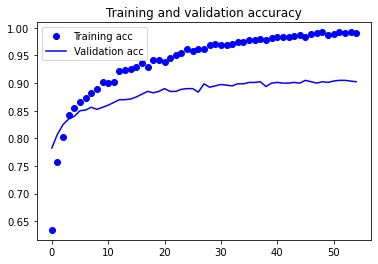

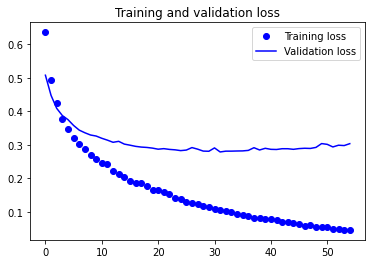

In [169]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Image Augmentation 

In [233]:
from keras import models
from keras import layers
from keras.layers import Dense, Activation, Dropout, Input

model_3 = models.Sequential()
model_3.add(conv_base)
model_3.add(layers.Flatten())
model_3.add(layers.Dense(256, activation='relu'))
model_3.add(layers.Dense(1, activation='sigmoid'))
model_3.add(Dropout(0.5))

In [234]:
# dont wanna train the base again
conv_base.trainable = False



In [235]:
from keras.preprocessing.image import ImageDataGenerator

# data augmentation configuration 
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        val,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model_3.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model_3.fit_generator(
      train_generator,
      steps_per_epoch=len(train)//batch_size,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=20,
      verbose=2)



Found 2398 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


/Users/jamesgardner/opt/anaconda3/envs/metis/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
/Users/jamesgardner/opt/anaconda3/envs/metis/lib/python3.8/site-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
3/3 - 32s - loss: 6.8850 - acc: 0.4667 - val_loss: 0.7385 - val_acc: 0.4975
Epoch 2/30
3/3 - 27s - loss: 4.8130 - acc: 0.5167 - val_loss: 0.8165 - val_acc: 0.4900
Epoch 3/30
3/3 - 28s - loss: 3.5316 - acc: 0.6034 - val_loss: 0.8153 - val_acc: 0.5050
Epoch 4/30
3/3 - 28s - loss: 4.4520 - acc: 0.5000 - val_loss: 0.8025 - val_acc: 0.5225
Epoch 5/30
3/3 - 28s - loss: 3.6400 - acc: 0.6000 - val_loss: 0.8348 - val_acc: 0.5025
Epoch 6/30
3/3 - 27s - loss: 4.2064 - acc: 0.5167 - val_loss: 0.8500 - val_acc: 0.5200
Epoch 7/30
3/3 - 27s - loss: 4.4764 - acc: 0.5000 - val_loss: 0.8462 - val_acc: 0.4950
Epoch 8/30
3/3 - 26s - loss: 5.0149 - acc: 0.4833 - val_loss: 0.8029 - val_acc: 0.5100
Epoch 9/30
3/3 - 28s - loss: 2.9332 - acc: 0.6000 - val_loss: 0.8721 - val_acc: 0.4775
Epoch 10/30
3/3 - 27s - loss: 4.2570 - acc: 0.5500 - val_loss: 0.8162 - val_acc: 0.4825
Epoch 11/30
3/3 - 27s - loss: 2.6546 - acc: 0.6500 - val_loss: 0.8462 - val_acc: 0.4850
Epoch 12/30
3/3 - 27s - loss: 4.6441 - ac

In [89]:
# Testing on images outside my data set 
test_pets = '/Users/jamesgardner/Desktop/test_pets'
test_features_pets, test_labels_pets,generator_test_pets = extract_features(test_pets, 6)

Found 6 images belonging to 2 classes.
